In [25]:
import os
import tarfile
import urllib.request
import email
import email.policy
from collections import Counter
import re
from html import unescape
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
from nltk.stem import PorterStemmer
from urlextract import URLExtract
from sklearn.base import BaseEstimator, TransformerMixin
from tqdm import tqdm
from scipy.sparse import csr_matrix

# Ensure  NLTK resources downloaded
nltk.download('punkt')
try:
    nltk.download('stopwords')
except Exception:
    pass

# Check for GPU availability
device = torch.device("mps")

# Data Fetching
DOWNLOAD_ROOT = "http://spamassassin.apache.org/old/publiccorpus/"
HAM_URL = DOWNLOAD_ROOT + "20030228_easy_ham.tar.bz2"
SPAM_URL = DOWNLOAD_ROOT + "20030228_spam.tar.bz2"
SPAM_PATH = os.path.join("datasets", "spam")

def fetch_spam_data(ham_url=HAM_URL, spam_url=SPAM_URL, spam_path=SPAM_PATH):
    if not os.path.isdir(spam_path):
        os.makedirs(spam_path)
    for filename, url in (("ham.tar.bz2", ham_url), ("spam.tar.bz2", spam_url)):
        path = os.path.join(spam_path, filename)
        if not os.path.isfile(path):
            urllib.request.urlretrieve(url, path)
        with tarfile.open(path) as tar_bz2_file:
            tar_bz2_file.extractall(path=spam_path)

fetch_spam_data()

HAM_DIR = os.path.join(SPAM_PATH, "easy_ham")
SPAM_DIR = os.path.join(SPAM_PATH, "spam")
ham_filenames = [name for name in sorted(os.listdir(HAM_DIR)) if len(name) > 20]
spam_filenames = [name for name in sorted(os.listdir(SPAM_DIR)) if len(name) > 20]

def load_email(is_spam, filename, spam_path=SPAM_PATH):
    directory = "spam" if is_spam else "easy_ham"
    with open(os.path.join(spam_path, directory, filename), "rb") as f:
        return email.parser.BytesParser(policy=email.policy.default).parse(f)

ham_emails = [load_email(is_spam=False, filename=name) for name in ham_filenames]
spam_emails = [load_email(is_spam=True, filename=name) for name in spam_filenames]


# Preprocessing Functions
from collections import Counter

def get_email_structure(email):
    if isinstance(email, str):
        return email
    payload = email.get_payload()
    if isinstance(payload, list):
        return "multipart({})".format(", ".join([
            get_email_structure(sub_email)
            for sub_email in payload
        ]))
    else:
        return email.get_content_type()

def email_to_text(email):
    html = None
    for part in email.walk():
        ctype = part.get_content_type()
        if not ctype in ("text/plain", "text/html"):
            continue
        try:
            content = part.get_content()
        except: # in case of encoding issues
            content = str(part.get_payload())
        if ctype == "text/plain":
            return content
        else:
            html = content
    if html:
        return html_to_plain_text(html)

def html_to_plain_text(html):
    text = re.sub('<head.*?>.*?</head>', '', html, flags=re.M | re.S | re.I)
    text = re.sub('<a\s.*?>', ' HYPERLINK ', text, flags=re.M | re.S | re.I)
    text = re.sub('<.*?>', '', text, flags=re.M | re.S)
    text = re.sub(r'(\s*\n)+', '\n', text, flags=re.M | re.S)
    return unescape(text)

# NLTK components initialization
stemmer = PorterStemmer()
url_extractor = URLExtract()

# Feature Extraction and Transformation
class EmailToFeatureTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, strip_headers=True, lower_case=True, remove_punctuation=True,
                 replace_urls=True, replace_numbers=True, stemming=True):
        self.strip_headers = strip_headers
        self.lower_case = lower_case
        self.remove_punctuation = remove_punctuation
        self.replace_urls = replace_urls
        self.replace_numbers = replace_numbers
        self.stemming = stemming
        
    def fit(self, X, y=None):
        # No fitting necessary for this transformer
        return self

    def transform(self, X, y=None):
        X_transformed = []
        for email in X:
            text = email_to_text(email) or ""
            if self.lower_case:
                text = text.lower()
            if self.replace_urls:
                urls = list(set(url_extractor.find_urls(text)))
                for url in urls:
                    text = text.replace(url, " URL ")
            if self.replace_numbers:
                text = re.sub(r'\d+', 'NUMBER', text)
            if self.remove_punctuation:
                text = re.sub(r'\W+', ' ', text, flags=re.M)
            if self.stemming:
                text = ' '.join([stemmer.stem(word) for word in text.split()])
            X_transformed.append(text)
        return X_transformed

# Combine all preprocessing and feature extraction steps into a pipeline
preprocessing_pipeline = Pipeline([
    ("to_feature", EmailToFeatureTransformer()),
    ("tfidf", TfidfVectorizer(stop_words="english", max_features=1000))
])

# Prepare Data
X = np.array(ham_emails + spam_emails, dtype=object)
y = np.array([0] * len(ham_emails) + [1] * len(spam_emails))

# Apply the preprocessing pipeline
X_processed = preprocessing_pipeline.fit_transform(X)
X_tensor = torch.tensor(X_processed.toarray(), dtype=torch.float32).to(device)
y_tensor = torch.tensor(y, dtype=torch.float32).to(device)

# Split into train and test sets
X_train_tensor, X_test_tensor, y_train_tensor, y_test_tensor = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

# Custom Dataset
class EmailDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

# Neural Network Model
class LogisticRegressionNN(nn.Module):
    def __init__(self, input_size):
        super(LogisticRegressionNN, self).__init__()
        self.linear = nn.Linear(input_size, 1)
    
    def forward(self, x):
        return torch.sigmoid(self.linear(x))

    
# Create datasets and loaders
train_dataset = EmailDataset(X_train_tensor, y_train_tensor)
test_dataset = EmailDataset(X_test_tensor, y_test_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize model, loss function, and optimizer
input_size = 1000  # Adjust based on your feature extraction
model = LogisticRegressionNN(input_size).to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

from sklearn.metrics import precision_score, recall_score

# Metrics recording
train_losses, val_losses = [], []
train_precision, train_recall = [], []
val_precision, val_recall = [], []

# Training and Validation Loop
num_epochs = 100  # Adjust as needed

for epoch in tqdm(range(num_epochs)):
    model.train()
    total_loss = 0
    true_labels = []
    predicted_labels = []

    for emails, labels in train_loader:
        emails, labels = emails.to(device), labels.to(device)

        # Forward pass
        outputs = model(emails)
        loss = criterion(outputs.squeeze(), labels)
        total_loss += loss.item()

        # Convert outputs to binary predictions
        predictions = (outputs.squeeze() > 0.5).float()
        true_labels.extend(labels.tolist())
        predicted_labels.extend(predictions.tolist())

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_losses.append(total_loss / len(train_loader))
    train_precision.append(precision_score(true_labels, predicted_labels))
    train_recall.append(recall_score(true_labels, predicted_labels))

    # Validation phase
    model.eval()
    val_loss = 0
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for emails, labels in test_loader:
            emails, labels = emails.to(device), labels.to(device)
            outputs = model(emails)
            loss = criterion(outputs.squeeze(), labels)
            val_loss += loss.item()

            predictions = (outputs.squeeze() > 0.5).float()
            true_labels.extend(labels.tolist())
            predicted_labels.extend(predictions.tolist())

    val_losses.append(val_loss / len(test_loader))
    val_precision.append(precision_score(true_labels, predicted_labels))
    val_recall.append(recall_score(true_labels, predicted_labels))

    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {train_losses[-1]:.4f}, Validation Loss: {val_losses[-1]:.4f}')



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/robertovita/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/robertovita/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
  0%|                                                   | 0/100 [00:00<?, ?it/s]/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  1%|▍                                          | 1/100 [00:00<01:07,  1.47it/s]

Epoch [1/100], Loss: 0.6391, Validation Loss: 0.5906


/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  2%|▊                                          | 2/100 [00:01<01:06,  1.48it/s]

Epoch [2/100], Loss: 0.5557, Validation Loss: 0.5196


/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  3%|█▎                                         | 3/100 [00:02<01:06,  1.47it/s]

Epoch [3/100], Loss: 0.4946, Validation Loss: 0.4675


/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
  4%|█▋                                         | 4/100 [00:02<01:05,  1.47it/s]

Epoch [4/100], Loss: 0.4486, Validation Loss: 0.4276


  5%|██▏                                        | 5/100 [00:03<01:04,  1.47it/s]

Epoch [5/100], Loss: 0.4129, Validation Loss: 0.3962


  6%|██▌                                        | 6/100 [00:04<01:03,  1.47it/s]

Epoch [6/100], Loss: 0.3839, Validation Loss: 0.3703


  7%|███                                        | 7/100 [00:04<01:03,  1.47it/s]

Epoch [7/100], Loss: 0.3597, Validation Loss: 0.3487


  8%|███▍                                       | 8/100 [00:05<01:02,  1.47it/s]

Epoch [8/100], Loss: 0.3389, Validation Loss: 0.3299


  9%|███▊                                       | 9/100 [00:06<01:01,  1.47it/s]

Epoch [9/100], Loss: 0.3206, Validation Loss: 0.3134


 10%|████▏                                     | 10/100 [00:06<01:00,  1.48it/s]

Epoch [10/100], Loss: 0.3042, Validation Loss: 0.2986


 11%|████▌                                     | 11/100 [00:07<01:00,  1.48it/s]

Epoch [11/100], Loss: 0.2894, Validation Loss: 0.2851


 12%|█████                                     | 12/100 [00:08<00:59,  1.48it/s]

Epoch [12/100], Loss: 0.2758, Validation Loss: 0.2728


 13%|█████▍                                    | 13/100 [00:08<00:58,  1.49it/s]

Epoch [13/100], Loss: 0.2632, Validation Loss: 0.2616


 14%|█████▉                                    | 14/100 [00:09<00:57,  1.49it/s]

Epoch [14/100], Loss: 0.2517, Validation Loss: 0.2512


 15%|██████▎                                   | 15/100 [00:10<00:56,  1.49it/s]

Epoch [15/100], Loss: 0.2409, Validation Loss: 0.2415


 16%|██████▋                                   | 16/100 [00:10<00:56,  1.49it/s]

Epoch [16/100], Loss: 0.2309, Validation Loss: 0.2325


 17%|███████▏                                  | 17/100 [00:11<00:55,  1.49it/s]

Epoch [17/100], Loss: 0.2216, Validation Loss: 0.2242


 18%|███████▌                                  | 18/100 [00:12<00:54,  1.49it/s]

Epoch [18/100], Loss: 0.2129, Validation Loss: 0.2164


 19%|███████▉                                  | 19/100 [00:12<00:54,  1.49it/s]

Epoch [19/100], Loss: 0.2048, Validation Loss: 0.2091


 20%|████████▍                                 | 20/100 [00:13<00:54,  1.48it/s]

Epoch [20/100], Loss: 0.1972, Validation Loss: 0.2022


 21%|████████▊                                 | 21/100 [00:14<00:53,  1.47it/s]

Epoch [21/100], Loss: 0.1900, Validation Loss: 0.1958


 22%|█████████▏                                | 22/100 [00:14<00:53,  1.46it/s]

Epoch [22/100], Loss: 0.1833, Validation Loss: 0.1898


 23%|█████████▋                                | 23/100 [00:15<00:52,  1.47it/s]

Epoch [23/100], Loss: 0.1769, Validation Loss: 0.1842


 24%|██████████                                | 24/100 [00:16<00:51,  1.47it/s]

Epoch [24/100], Loss: 0.1709, Validation Loss: 0.1787


 25%|██████████▌                               | 25/100 [00:16<00:51,  1.47it/s]

Epoch [25/100], Loss: 0.1653, Validation Loss: 0.1737


 26%|██████████▉                               | 26/100 [00:17<00:50,  1.47it/s]

Epoch [26/100], Loss: 0.1599, Validation Loss: 0.1689


 27%|███████████▎                              | 27/100 [00:18<00:49,  1.47it/s]

Epoch [27/100], Loss: 0.1549, Validation Loss: 0.1644


 28%|███████████▊                              | 28/100 [00:18<00:48,  1.47it/s]

Epoch [28/100], Loss: 0.1501, Validation Loss: 0.1601


 29%|████████████▏                             | 29/100 [00:19<00:48,  1.47it/s]

Epoch [29/100], Loss: 0.1456, Validation Loss: 0.1561


 30%|████████████▌                             | 30/100 [00:20<00:47,  1.47it/s]

Epoch [30/100], Loss: 0.1413, Validation Loss: 0.1522


 31%|█████████████                             | 31/100 [00:20<00:46,  1.47it/s]

Epoch [31/100], Loss: 0.1372, Validation Loss: 0.1486


 32%|█████████████▍                            | 32/100 [00:21<00:46,  1.47it/s]

Epoch [32/100], Loss: 0.1333, Validation Loss: 0.1451


 33%|█████████████▊                            | 33/100 [00:22<00:45,  1.47it/s]

Epoch [33/100], Loss: 0.1296, Validation Loss: 0.1418


 34%|██████████████▎                           | 34/100 [00:23<00:44,  1.47it/s]

Epoch [34/100], Loss: 0.1260, Validation Loss: 0.1386


 35%|██████████████▋                           | 35/100 [00:23<00:44,  1.46it/s]

Epoch [35/100], Loss: 0.1226, Validation Loss: 0.1356


 36%|███████████████                           | 36/100 [00:24<00:44,  1.44it/s]

Epoch [36/100], Loss: 0.1194, Validation Loss: 0.1327


 37%|███████████████▌                          | 37/100 [00:25<00:44,  1.43it/s]

Epoch [37/100], Loss: 0.1163, Validation Loss: 0.1299


 38%|███████████████▉                          | 38/100 [00:25<00:43,  1.43it/s]

Epoch [38/100], Loss: 0.1134, Validation Loss: 0.1272


 39%|████████████████▍                         | 39/100 [00:26<00:42,  1.42it/s]

Epoch [39/100], Loss: 0.1105, Validation Loss: 0.1247


 40%|████████████████▊                         | 40/100 [00:27<00:42,  1.42it/s]

Epoch [40/100], Loss: 0.1078, Validation Loss: 0.1222


 41%|█████████████████▏                        | 41/100 [00:27<00:41,  1.44it/s]

Epoch [41/100], Loss: 0.1052, Validation Loss: 0.1199


 42%|█████████████████▋                        | 42/100 [00:28<00:40,  1.45it/s]

Epoch [42/100], Loss: 0.1027, Validation Loss: 0.1176


 43%|██████████████████                        | 43/100 [00:29<00:39,  1.46it/s]

Epoch [43/100], Loss: 0.1003, Validation Loss: 0.1155


 44%|██████████████████▍                       | 44/100 [00:30<00:38,  1.45it/s]

Epoch [44/100], Loss: 0.0980, Validation Loss: 0.1134


 45%|██████████████████▉                       | 45/100 [00:30<00:37,  1.46it/s]

Epoch [45/100], Loss: 0.0957, Validation Loss: 0.1114


 46%|███████████████████▎                      | 46/100 [00:31<00:37,  1.44it/s]

Epoch [46/100], Loss: 0.0936, Validation Loss: 0.1094


 47%|███████████████████▋                      | 47/100 [00:32<00:36,  1.43it/s]

Epoch [47/100], Loss: 0.0915, Validation Loss: 0.1076


 48%|████████████████████▏                     | 48/100 [00:32<00:35,  1.45it/s]

Epoch [48/100], Loss: 0.0895, Validation Loss: 0.1058


 49%|████████████████████▌                     | 49/100 [00:33<00:35,  1.45it/s]

Epoch [49/100], Loss: 0.0876, Validation Loss: 0.1041


 50%|█████████████████████                     | 50/100 [00:34<00:34,  1.45it/s]

Epoch [50/100], Loss: 0.0858, Validation Loss: 0.1024


 51%|█████████████████████▍                    | 51/100 [00:34<00:34,  1.44it/s]

Epoch [51/100], Loss: 0.0839, Validation Loss: 0.1008


 52%|█████████████████████▊                    | 52/100 [00:35<00:33,  1.43it/s]

Epoch [52/100], Loss: 0.0822, Validation Loss: 0.0992


 53%|██████████████████████▎                   | 53/100 [00:36<00:32,  1.44it/s]

Epoch [53/100], Loss: 0.0805, Validation Loss: 0.0977


 54%|██████████████████████▋                   | 54/100 [00:36<00:32,  1.43it/s]

Epoch [54/100], Loss: 0.0789, Validation Loss: 0.0962


 55%|███████████████████████                   | 55/100 [00:37<00:31,  1.45it/s]

Epoch [55/100], Loss: 0.0773, Validation Loss: 0.0948


 56%|███████████████████████▌                  | 56/100 [00:38<00:30,  1.45it/s]

Epoch [56/100], Loss: 0.0758, Validation Loss: 0.0934


 57%|███████████████████████▉                  | 57/100 [00:39<00:29,  1.45it/s]

Epoch [57/100], Loss: 0.0743, Validation Loss: 0.0921


 58%|████████████████████████▎                 | 58/100 [00:39<00:29,  1.44it/s]

Epoch [58/100], Loss: 0.0729, Validation Loss: 0.0907


 59%|████████████████████████▊                 | 59/100 [00:40<00:28,  1.44it/s]

Epoch [59/100], Loss: 0.0715, Validation Loss: 0.0895


 60%|█████████████████████████▏                | 60/100 [00:41<00:27,  1.44it/s]

Epoch [60/100], Loss: 0.0702, Validation Loss: 0.0883


 61%|█████████████████████████▌                | 61/100 [00:41<00:26,  1.45it/s]

Epoch [61/100], Loss: 0.0688, Validation Loss: 0.0871


 62%|██████████████████████████                | 62/100 [00:42<00:26,  1.46it/s]

Epoch [62/100], Loss: 0.0676, Validation Loss: 0.0860


 63%|██████████████████████████▍               | 63/100 [00:43<00:25,  1.44it/s]

Epoch [63/100], Loss: 0.0663, Validation Loss: 0.0848


 64%|██████████████████████████▉               | 64/100 [00:43<00:25,  1.42it/s]

Epoch [64/100], Loss: 0.0651, Validation Loss: 0.0837


 65%|███████████████████████████▎              | 65/100 [00:44<00:24,  1.43it/s]

Epoch [65/100], Loss: 0.0640, Validation Loss: 0.0827


 66%|███████████████████████████▋              | 66/100 [00:45<00:23,  1.44it/s]

Epoch [66/100], Loss: 0.0628, Validation Loss: 0.0817


 67%|████████████████████████████▏             | 67/100 [00:45<00:22,  1.45it/s]

Epoch [67/100], Loss: 0.0617, Validation Loss: 0.0806


 68%|████████████████████████████▌             | 68/100 [00:46<00:22,  1.45it/s]

Epoch [68/100], Loss: 0.0606, Validation Loss: 0.0797


 69%|████████████████████████████▉             | 69/100 [00:47<00:21,  1.43it/s]

Epoch [69/100], Loss: 0.0596, Validation Loss: 0.0787


 70%|█████████████████████████████▍            | 70/100 [00:48<00:20,  1.44it/s]

Epoch [70/100], Loss: 0.0586, Validation Loss: 0.0778


 71%|█████████████████████████████▊            | 71/100 [00:48<00:20,  1.44it/s]

Epoch [71/100], Loss: 0.0575, Validation Loss: 0.0768


 72%|██████████████████████████████▏           | 72/100 [00:49<00:19,  1.45it/s]

Epoch [72/100], Loss: 0.0566, Validation Loss: 0.0760


 73%|██████████████████████████████▋           | 73/100 [00:50<00:18,  1.46it/s]

Epoch [73/100], Loss: 0.0556, Validation Loss: 0.0751


 74%|███████████████████████████████           | 74/100 [00:50<00:17,  1.45it/s]

Epoch [74/100], Loss: 0.0547, Validation Loss: 0.0743


 75%|███████████████████████████████▌          | 75/100 [00:51<00:17,  1.45it/s]

Epoch [75/100], Loss: 0.0538, Validation Loss: 0.0734


 76%|███████████████████████████████▉          | 76/100 [00:52<00:16,  1.45it/s]

Epoch [76/100], Loss: 0.0529, Validation Loss: 0.0727


 77%|████████████████████████████████▎         | 77/100 [00:52<00:15,  1.45it/s]

Epoch [77/100], Loss: 0.0520, Validation Loss: 0.0718


 78%|████████████████████████████████▊         | 78/100 [00:53<00:15,  1.45it/s]

Epoch [78/100], Loss: 0.0512, Validation Loss: 0.0711


 79%|█████████████████████████████████▏        | 79/100 [00:54<00:14,  1.44it/s]

Epoch [79/100], Loss: 0.0504, Validation Loss: 0.0703


 80%|█████████████████████████████████▌        | 80/100 [00:54<00:13,  1.45it/s]

Epoch [80/100], Loss: 0.0496, Validation Loss: 0.0696


 81%|██████████████████████████████████        | 81/100 [00:55<00:13,  1.45it/s]

Epoch [81/100], Loss: 0.0488, Validation Loss: 0.0689


 82%|██████████████████████████████████▍       | 82/100 [00:56<00:12,  1.46it/s]

Epoch [82/100], Loss: 0.0480, Validation Loss: 0.0682


 83%|██████████████████████████████████▊       | 83/100 [00:56<00:11,  1.46it/s]

Epoch [83/100], Loss: 0.0473, Validation Loss: 0.0675


 84%|███████████████████████████████████▎      | 84/100 [00:57<00:10,  1.47it/s]

Epoch [84/100], Loss: 0.0465, Validation Loss: 0.0668


 85%|███████████████████████████████████▋      | 85/100 [00:58<00:10,  1.47it/s]

Epoch [85/100], Loss: 0.0458, Validation Loss: 0.0662


 86%|████████████████████████████████████      | 86/100 [00:59<00:09,  1.46it/s]

Epoch [86/100], Loss: 0.0451, Validation Loss: 0.0655


 87%|████████████████████████████████████▌     | 87/100 [00:59<00:08,  1.45it/s]

Epoch [87/100], Loss: 0.0444, Validation Loss: 0.0649


 88%|████████████████████████████████████▉     | 88/100 [01:00<00:08,  1.45it/s]

Epoch [88/100], Loss: 0.0438, Validation Loss: 0.0643


 89%|█████████████████████████████████████▍    | 89/100 [01:01<00:07,  1.45it/s]

Epoch [89/100], Loss: 0.0431, Validation Loss: 0.0637


 90%|█████████████████████████████████████▊    | 90/100 [01:01<00:06,  1.46it/s]

Epoch [90/100], Loss: 0.0425, Validation Loss: 0.0631


 91%|██████████████████████████████████████▏   | 91/100 [01:02<00:06,  1.46it/s]

Epoch [91/100], Loss: 0.0418, Validation Loss: 0.0625


 92%|██████████████████████████████████████▋   | 92/100 [01:03<00:05,  1.46it/s]

Epoch [92/100], Loss: 0.0412, Validation Loss: 0.0620


 93%|███████████████████████████████████████   | 93/100 [01:03<00:04,  1.45it/s]

Epoch [93/100], Loss: 0.0406, Validation Loss: 0.0614


 94%|███████████████████████████████████████▍  | 94/100 [01:04<00:04,  1.45it/s]

Epoch [94/100], Loss: 0.0400, Validation Loss: 0.0609


 95%|███████████████████████████████████████▉  | 95/100 [01:05<00:03,  1.46it/s]

Epoch [95/100], Loss: 0.0394, Validation Loss: 0.0603


 96%|████████████████████████████████████████▎ | 96/100 [01:05<00:02,  1.45it/s]

Epoch [96/100], Loss: 0.0389, Validation Loss: 0.0598


 97%|████████████████████████████████████████▋ | 97/100 [01:06<00:02,  1.44it/s]

Epoch [97/100], Loss: 0.0383, Validation Loss: 0.0593


 98%|█████████████████████████████████████████▏| 98/100 [01:07<00:01,  1.43it/s]

Epoch [98/100], Loss: 0.0378, Validation Loss: 0.0588


 99%|█████████████████████████████████████████▌| 99/100 [01:08<00:00,  1.44it/s]

Epoch [99/100], Loss: 0.0372, Validation Loss: 0.0583


100%|█████████████████████████████████████████| 100/100 [01:08<00:00,  1.45it/s]

Epoch [100/100], Loss: 0.0367, Validation Loss: 0.0579


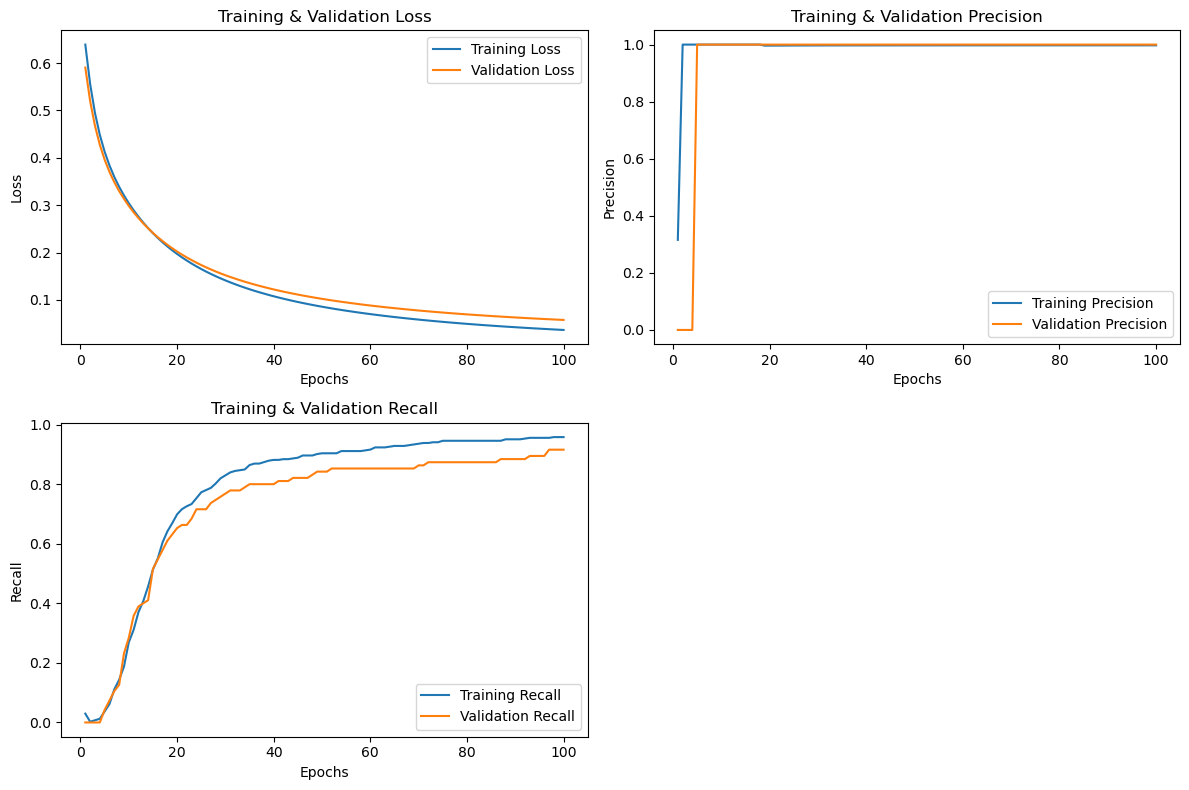

In [26]:
# Plotting
import matplotlib.pyplot as plt

epochs = range(1, num_epochs + 1)
plt.figure(figsize=(12, 8))

plt.subplot(2, 2, 1)
plt.plot(epochs, train_losses, label='Training Loss')
plt.plot(epochs, val_losses, label='Validation Loss')
plt.title('Training & Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 2, 2)
plt.plot(epochs, train_precision, label='Training Precision')
plt.plot(epochs, val_precision, label='Validation Precision')
plt.title('Training & Validation Precision')
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.legend()

plt.subplot(2, 2, 3)
plt.plot(epochs, train_recall, label='Training Recall')
plt.plot(epochs, val_recall, label='Validation Recall')
plt.title('Training & Validation Recall')
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.legend()

plt.tight_layout()
plt.show()


In [27]:
# Final Evaluation on Test Set
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for emails, labels in test_loader:
        emails, labels = emails.to(device), labels.to(device)
        outputs = model(emails)
        predictions = (outputs.squeeze() > 0.5).float()

        y_true.extend(labels.tolist())
        y_pred.extend(predictions.tolist())

# Calculating Precision and Recall
precision = precision_score(y_true, y_pred)
recall = recall_score(y_true, y_pred)

print(f"Precision: {precision * 100:.2f}%")
print(f"Recall: {recall * 100:.2f}%")


Precision: 100.00%
Recall: 91.58%
